# Heart Disease Prediction
**Team:** Avilipsa Mahapatra[23051664] / Yogesh Kumar[23051397]  
**Dataset:** Heart Disease Prediction (Kaggle) 
**Date:** 27 October 2025


**1) Setup — imports & load data**

In [ ]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
from pathlib import Path
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import joblib

DATA_PATH = "C:\Projects\HeartDiseasePrediction\Heart_Disease_Prediction.csv"   # update path if needed
df = pd.read_csv(DATA_PATH)
df.shape, df.columns


((270, 14),
 Index(['Age', 'Sex', 'Chest pain type', 'BP', 'Cholesterol', 'FBS over 120',
        'EKG results', 'Max HR', 'Exercise angina', 'ST depression',
        'Slope of ST', 'Number of vessels fluro', 'Thallium', 'Heart Disease'],
       dtype='object'))

**2) Quick inspection**

In [ ]:
display(df.head())
df.info()
df.describe(include='all').T
print("Missing values:\n", df.isnull().sum())


,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      270 non-null    int64  
 1   Sex                      270 non-null    int64  
 2   Chest pain type          270 non-null    int64  
 3   BP                       270 non-null    int64  
 4   Cholesterol              270 non-null    int64  
 5   FBS over 120             270 non-null    int64  
 6   EKG results              270 non-null    int64  
 7   Max HR                   270 non-null    int64  
 8   Exercise angina          270 non-null    int64  
 9   ST depression            270 non-null    float64
 10  Slope of ST              270 non-null    int64  
 11  Number of vessels fluro  270 non-null    int64  
 12  Thallium                 270 non-null    int64  
 13  Heart Disease            270 non-null    object 
dtypes: float64(1), int64(12), 

**3) Map target to 0/1 if necessary**

In [ ]:
target_col = "Heart Disease"   # change if your target column name differs
y = df[target_col]
if y.dtype == object or y.dtype.name == 'category':
    unique = y.unique().tolist()
    print("Unique target values:", unique)
    # common mapping:
    mapping = {"Absence":0, "Presence":1}
    # fallback: map first->0 second->1
    if not set(unique).issubset(set(mapping.keys())):
        mapping = {unique[0]:0, unique[1]:1}
    y = y.map(mapping)
X = df.drop(columns=[target_col])


Unique target values: ['Presence', 'Absence']


**4) Cleaning & preprocessing**

In [ ]:
num_cols = X.select_dtypes(include='number').columns.tolist()
cat_cols = X.select_dtypes(exclude='number').columns.tolist()

# Impute
if X[num_cols].isnull().sum().sum() > 0:
    X[num_cols] = SimpleImputer(strategy='median').fit_transform(X[num_cols])
if len(cat_cols)>0 and X[cat_cols].isnull().sum().sum() > 0:
    X[cat_cols] = SimpleImputer(strategy='most_frequent').fit_transform(X[cat_cols])

# One-hot encode categoricals
if len(cat_cols)>0:
    X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

# IQR capping (optional)
def cap_iqr(col):
    q1, q3 = col.quantile(0.25), col.quantile(0.75)
    iqr = q3-q1
    return col.clip(q1 - 1.5*iqr, q3 + 1.5*iqr)
for c in num_cols:
    if c in X.columns:
        X[c] = cap_iqr(X[c])


**5) Exploratory Data Analysis(EDA) Report**

5A - Target distribution

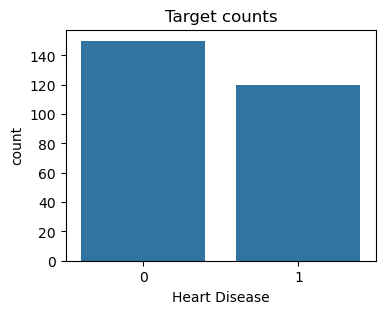

In [ ]:
plt.figure(figsize=(4,3))
sns.countplot(x=y)
plt.title("Target counts")
plt.show()


**Insights:**
- The dataset is slightly balanced (similar counts for Presence and Absence of heart disease).
- This suggests we can use accuracy and F1-score fairly without needing to handle severe imbalance.


5B - Correlation

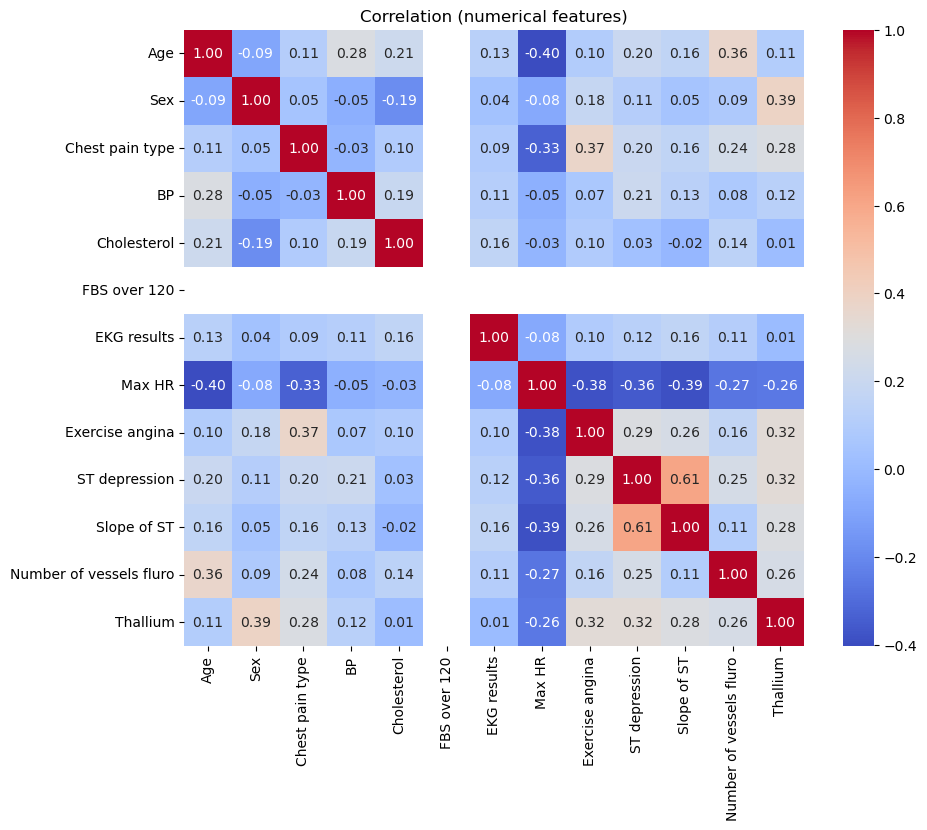

In [ ]:
plt.figure(figsize=(10,8))
sns.heatmap(X[num_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation (numerical features)")
plt.show()


5C - histograms and boxplots

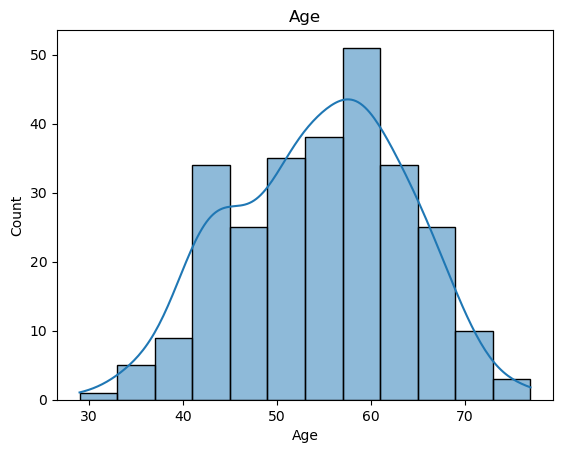

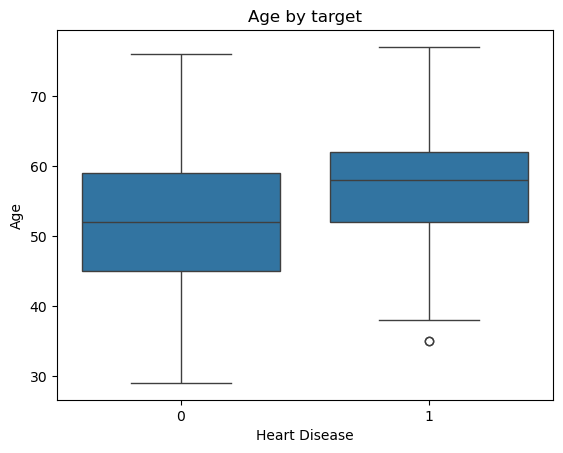

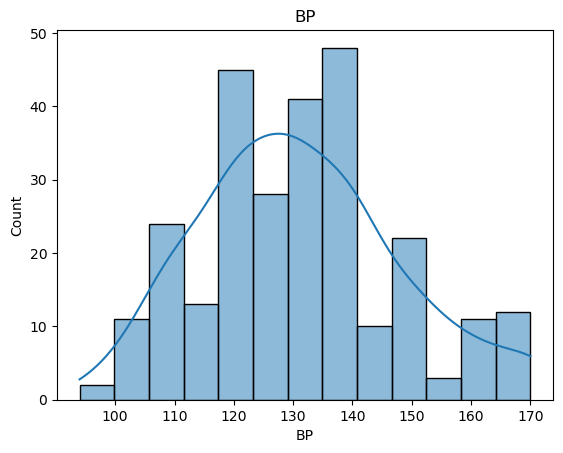

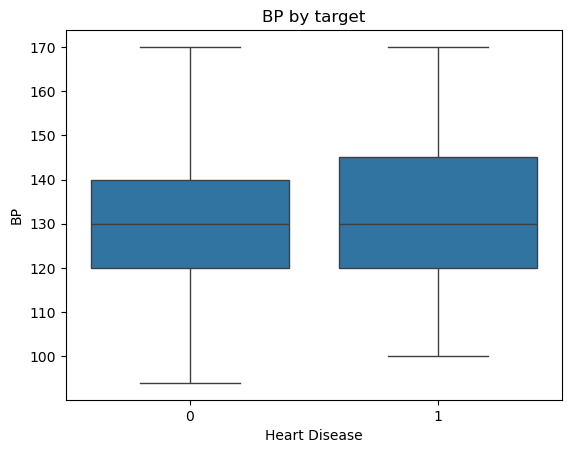

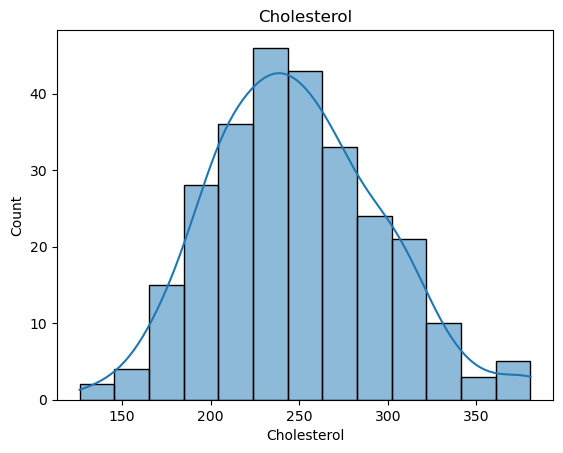

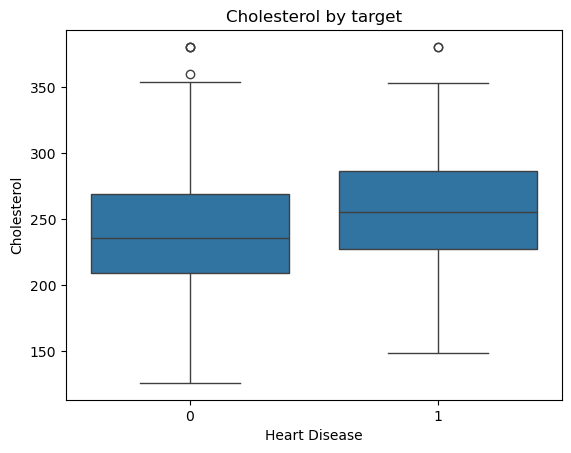

In [27]:
for col in ['Age','BP','Cholesterol'][:3]:   # change names to actual columns
    if col in X.columns:
        plt.figure(); sns.histplot(X[col], kde=True); plt.title(col); plt.show()
        plt.figure(); sns.boxplot(x=y, y=X[col]); plt.title(f"{col} by target"); plt.show()





### Insights:
- **Age:** The majority of patients are between 40–60 years old, showing that middle-aged individuals form the largest group. Older patients (above 60) are fewer but show a higher tendency toward heart disease.  
- **BP (Blood Pressure):** Most patients have blood pressure within a normal to slightly elevated range. Higher BP values are more common among patients with heart disease, indicating hypertension as a possible risk factor.  
- **Cholesterol:** Cholesterol levels vary widely, with several patients having values above the healthy range. Those with heart disease generally exhibit higher cholesterol, suggesting it is a strong predictive feature.  


**6) Train/test split & scaling**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)


**7) Train baseline models**

In [ ]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
}
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec  = recall_score(y_test, y_pred, zero_division=0)
    f1   = f1_score(y_test, y_pred, zero_division=0)
    cm   = confusion_matrix(y_test, y_pred)
    results.append({"Model":name,"Accuracy":acc,"Precision":prec,"Recall":rec,"F1":f1,"Confusion":cm})
    print(f"\n{name}  Acc:{acc:.4f} Prec:{prec:.4f} Rec:{rec:.4f} F1:{f1:.4f}\nConfusion:\n{cm}\n")
results_df = pd.DataFrame(results).sort_values("F1", ascending=False)
display(results_df)



LogisticRegression  Acc:0.8676 Prec:0.8182 Rec:0.9000 F1:0.8571
Confusion:
[[32  6]
 [ 3 27]]


DecisionTree  Acc:0.7500 Prec:0.7097 Rec:0.7333 F1:0.7213
Confusion:
[[29  9]
 [ 8 22]]


RandomForest  Acc:0.8382 Prec:0.7879 Rec:0.8667 F1:0.8254
Confusion:
[[31  7]
 [ 4 26]]



,Model,Accuracy,Precision,Recall,F1,Confusion
0,LogisticRegression,0.867647,0.818182,0.900000,0.857143,"[[32, 6], [3, 27]]"
2,RandomForest,0.838235,0.787879,0.866667,0.825397,"[[31, 7], [4, 26]]"
1,DecisionTree,0.750000,0.709677,0.733333,0.721311,"[[29, 9], [8, 22]]"


**8) Choose the model with highest F1 (or prefer Recall if missing a disease is costly).**


In [16]:
best = results_df.iloc[0]['Model']
best_model = models[best]
joblib.dump(best_model, "best_model.joblib")
print("Best model:", best)


Best model: LogisticRegression


**9) Cross-validation & basic hyperparameter tuning**

In [28]:
cv_scores = cross_val_score(LogisticRegression(max_iter=1000), scaler.fit_transform(X), y, cv=5, scoring='f1')
print("Logistic CV F1 mean ± std:", cv_scores.mean(), cv_scores.std())

# Example GridSearch for RandomForest (tune n_estimators, max_depth)
param_grid = {"n_estimators":[50,100,200], "max_depth":[None,6,10]}
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train_scaled, y_train)
print("Grid best params:", grid.best_params_, "best CV F1:", grid.best_score_)


Logistic CV F1 mean ± std: 0.8095713845205058 0.049068797670595375
Grid best params: {'max_depth': None, 'n_estimators': 50} best CV F1: 0.7776274018379281


**10) Final evaluation: confusion matrix, classification report, ROC AUC**

              precision    recall  f1-score   support

           0       0.91      0.84      0.88        38
           1       0.82      0.90      0.86        30

    accuracy                           0.87        68
   macro avg       0.87      0.87      0.87        68
weighted avg       0.87      0.87      0.87        68



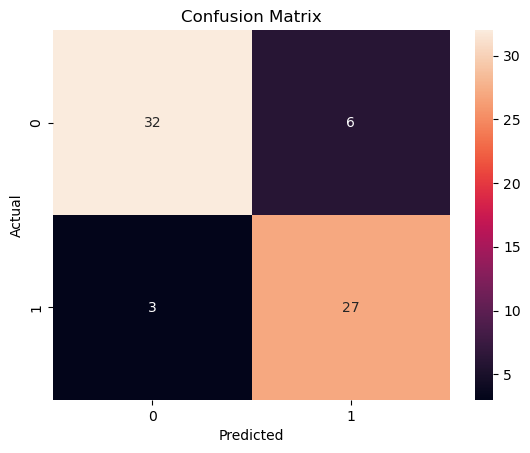

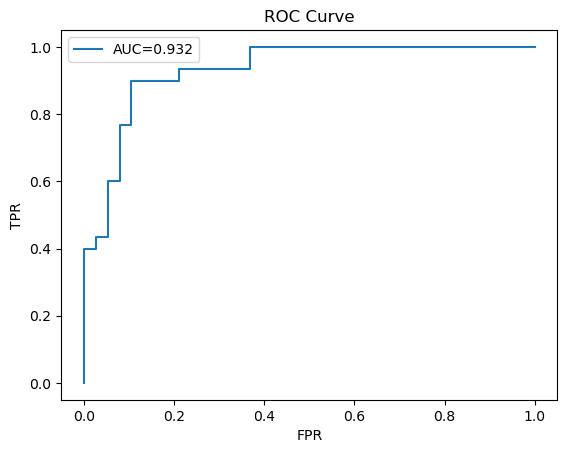

In [18]:
# Evaluate chosen model on test set
from sklearn.metrics import RocCurveDisplay
m = best_model
y_pred = m.predict(X_test_scaled)
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d"); plt.title("Confusion Matrix"); plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.show()

# ROC AUC (if model supports predict_proba)
if hasattr(m, "predict_proba"):
    probs = m.predict_proba(X_test_scaled)[:,1]
    auc = roc_auc_score(y_test, probs)
    fpr, tpr, _ = roc_curve(y_test, probs)
    plt.figure(); plt.plot(fpr, tpr, label=f"AUC={auc:.3f}"); plt.xlabel("FPR"); plt.ylabel("TPR"); plt.legend(); plt.title("ROC Curve"); plt.show()


In [19]:
# If RandomForest used:
if isinstance(best_model, RandomForestClassifier):
    importances = pd.Series(best_model.feature_importances_, index=X.columns).sort_values(ascending=False)
    display(importances.head(10))
# If LogisticRegression used:
if isinstance(best_model, LogisticRegression):
    coefs = pd.Series(best_model.coef_[0], index=X.columns).sort_values(key=abs, ascending=False)
    display(coefs.head(10))


Number of vessels fluro    1.026004
Sex                        0.853454
Chest pain type            0.760711
Thallium                   0.545488
Cholesterol                0.462102
Max HR                    -0.457596
Exercise angina            0.423212
Slope of ST                0.375156
ST depression              0.320132
BP                         0.259524
dtype: float64

In [20]:
# Save artifacts
results_df.to_csv("model_results_summary.csv", index=False)
joblib.dump(best_model, "best_model.joblib")
print("Saved: model_results_summary.csv, best_model.joblib")


Saved: model_results_summary.csv, best_model.joblib
